In [2]:
"""
@author: liam connor
"""
import random

import numpy as np
import glob
from scipy import signal

try:
    import matplotlib
    matplotlib.use('Agg', warn=False)
    import matplotlib.pyplot as plt
except:
    plt = None
    pass

class Event(object):
    """ Class to generate a realistic fast radio burst and 
    add the event to data, including scintillation, temporal 
    scattering, spectral index variation, and DM smearing. 

    This class was expanded from real-time FRB injection 
    in Kiyoshi Masui's 
    https://github.com/kiyo-masui/burst\_search
    """
    def __init__(self, t_ref, f_ref, dm, fluence, width,
                 spec_ind, disp_ind=2, scat_tau_ref=0):
        self._t_ref = t_ref
        self._f_ref = f_ref
        self._dm = dm
        self._fluence = fluence
        self._width = width
        self._spec_ind = spec_ind
        self._disp_ind = disp_ind
        self._scat_tau_ref = scat_tau_ref
        self.width_max = width

    def disp_delay(self, f, _dm, _disp_ind=-2., k_DM=1e3/0.241):
        """ Calculate dispersion delay in seconds for 
        frequency,f, in MHz, _dm in pc cm**-3, and 
        a dispersion index, _disp_ind. 
        """
        return k_DM * _dm * (f**(-_disp_ind))

    def arrival_time(self, f):
        t = self.disp_delay(f, self._dm, self._disp_ind)
        t = t - self.disp_delay(self._f_ref, self._dm, self._disp_ind)
        return self._t_ref + t

    def calc_width(self, dm, freq_c, bw=400.0, NFREQ=1024,
                   ti=0.001, tsamp=0.001, tau=0.0):
        """ Calculated effective width of pulse 
        including DM smearing, sample time, etc.
        Input/output times are in seconds.
        """

        ti *= 1e3
        tsamp *= 1e3
        delta_freq = bw/NFREQ
        freq_c *= 1e-3 # convert MHz to GHz

        # tdm in milliseconds
        tdm = 8.3e-3 * dm * delta_freq / freq_c**3
        # these should in FWHM units, not a sigma 
        tdm /= 2.355
        tsamp /= 2.355
        tau *= 1e3
        # observed width in ms
        tI = np.sqrt(ti**2 + tsamp**2 + tdm**2 + tau**2)

        return 1e-3*tI

    def scintillation(self, freq):
        """ Include spectral scintillation across 
        the band. Approximate effect as a sinusoid, 
        with a random phase and a random decorrelation 
        bandwidth. 
        """
        # Make location of peaks / troughs random
        scint_phi = np.random.rand()
        f = np.linspace(0, 1, len(freq))

        # Make number of scintils between 0 and 10 (ish)
        nscint = np.exp(np.random.uniform(np.log(1e-3), np.log(7)))

        if nscint<1:
            nscint = 0
#        envelope = np.cos(nscint*(freq - self._f_ref)/self._f_ref + scint_phi)
        envelope = np.cos(2*np.pi*nscint*freq**-2/self._f_ref**-2 + scint_phi)
        envelope[envelope<0] = 0
        return envelope

    def gaussian_profile(self, nt, width, t0=0.):
        """ Use a normalized Gaussian window for the pulse, 
        rather than a boxcar.
        """
        t = np.linspace(-nt//2, nt//2, nt)
        g = np.exp(-(t-t0)**2 / (2*width**2))

        if not np.all(g > 0):
            g += 1e-18

        g /= g.max()

        return g

    def scat_profile(self, nt, f, tau=1.):
        """ Include exponential scattering profile. 
        """
#        tau_nu = tau * (f / self._f_ref)**-4.
        tau_nu = tau * (f / 1000.)**-4.
        t = np.linspace(0., nt//2, nt)

        prof = 1 / tau_nu * np.exp(-t / tau_nu)
        return prof / prof.max()

    def pulse_profile(self, nt, width, f, tau=0.,
                      t0=0., dm=0, delta_freq=300./1536, tsamp=0.00008192):
        """ Convolve the gaussian and scattering profiles 
        for final pulse shape at each frequency channel.

        Parameters
        ----------
        nt : int
            number of time samples
        width : int 
            gaussian width in samples
        f : float 
            frequency in MHz
        tau : int 
            scattering time at 1 GHz in samples
        t0  : 
        dm    : float
            dispersion measure 
        tsamp : float 
            sampling time in seconds
        delta_freq : float 
            freq channel width in MHz
    
        
        
        """
        gaus_prof = self.gaussian_profile(nt, width, t0=t0)

        tdm = 8.3e-6 * dm * delta_freq / (f*1e-3)**3
        tdm_samp = tdm/tsamp
        dm_smear_prof = np.ones([max(1, int(tdm_samp))])
        pulse_prof = signal.fftconvolve(gaus_prof, dm_smear_prof, mode='same')

        tau += 1e-18
        tau_nu = tau * (f / 1000.)**-4.
        scat_prof = self.scat_profile(nt, f, tau)
        pulse_prof = signal.fftconvolve(pulse_prof, scat_prof)[:nt]
        pulse_prof /= pulse_prof.max()

        pulse_prof *= (width/np.sqrt(width**2 + tau_nu**2 + tdm_samp**2))

        return pulse_prof

    def add_to_data(self, delta_t, freq, data,
                    scintillate=False, conv_dmsmear=False):
        """ Method to add already-dedispersed pulse 
        to background noise data. Includes frequency-dependent 
        width (smearing, scattering, etc.) and amplitude 
        (scintillation, spectral index). 
        """

        NFREQ = data.shape[0]
        NTIME = data.shape[1]
        tmid = NTIME//2

        if scintillate:
            scint_amp = self.scintillation(freq)

#        self._fluence /= np.sqrt(NFREQ)
        bandwidth = np.abs(freq[-1] - freq[0])
        tau_pix = self._scat_tau_ref/delta_t # scattering time in time samples

        if data.sum()==0:
            stds = 1
        else:
            stds = np.std(data)
        for ii, f in enumerate(freq):
            # if data[ii].sum()==0:
            #     continue

            # calculate dm-smeared and sampled 
            # pulse width for gaussian profil

            if conv_dmsmear:
                # account for DM smearing with boxcar convolution, set to zero here
                width_ = self.calc_width(0., f,
                                     bw=bandwidth, NFREQ=NFREQ,
                                     ti=self._width, tsamp=delta_t)
            else:
                width_ = self.calc_width(self._dm, f,
                                     bw=bandwidth, NFREQ=NFREQ,
                                     ti=self._width, tsamp=delta_t)

            index_width = max(1, (np.round((width_/ delta_t))).astype(int))
            tpix = int(self.arrival_time(f) / delta_t)

            if abs(tpix) >= tmid:
                # ensure that edges of data are not crossed
                continue

            if conv_dmsmear:
                pp = self.pulse_profile(NTIME, index_width, f,
                                    tau=tau_pix, t0=tpix, tsamp=delta_t,
                                    delta_freq=bandwidth/NFREQ, dm=self._dm)
            else:
                pp = self.pulse_profile(NTIME, index_width, f,
                                    tau=tau_pix, t0=tpix, tsamp=delta_t,
                                    delta_freq=bandwidth/NFREQ, dm=0.0)

            val = pp.copy()
            #val /= (val.max()*stds)
            val *= self._fluence
            val /= (self._width / delta_t)
            val = val * (f / self._f_ref) ** self._spec_ind
            #print(f, val.max(), self._fluence)

            if scintillate is True:
                val = (0.1 + scint_amp[ii]) * val

            data[ii] += val

        width_max = self.calc_width(self._dm, freq.max(),
                                    bw=bandwidth, NFREQ=NFREQ,
                                    ti=self._width, tsamp=delta_t, tau=self._scat_tau_ref)
        self.width_max = width_max

    def dm_transform(self, delta_t, data, freq, dm_max=10, dm_min=-10, NDM=50):
        """ Transform freq/time data to dm/time data.
        """

        if len(freq)<3:
            NFREQ = data.shape[0]
            freq = np.linspace(freq[0], freq[1], NFREQ)

        dm = np.linspace(dm_min, dm_max, NDM)
        ndm = len(dm)
        ntime = data.shape[-1]

        data_full = np.zeros([ndm, ntime])

        for ii, dm in enumerate(dm):
            for jj, f in enumerate(freq):
                self._dm = dm
                tpix = int(self.arrival_time(f) / delta_t)
                data_rot = np.roll(data[jj], tpix, axis=-1)
                data_full[ii] += data_rot

        return data_full

def dm_transform_filobj(data, dt, freqs, ref_freq=np.inf,
                 dm_min=-10, dm_max=10, ndm=50):
    """ Transform freq/time data to dm/time data.
    """
    import spectra
    nt = data.shape[1]
    ref_freq = 0.5*(freqs[0]+freqs[-1])

    datafilobj = spectra.Spectra(freqs, dt, data, starttime=0, dm=0)

    dms = np.linspace(dm_min, dm_max, 250)
    dmtarr = np.empty([250, nt])

    for ii, dm in enumerate(dms):
        datafilobj.dedisperse(dm, ref_freq=ref_freq)
        dmtarr[ii] = datafilobj.data.mean(0)

    return dmtarr

class EventSimulator():
    """Generates simulated fast radio bursts.
    Events occurrences are drawn from a Poissonian distribution.


    This class was expanded from real-time FRB injection 
    in Kiyoshi Masui's 
    https://github.com/kiyo-masui/burst\_search
    """

    def __init__(self, dm=(0.,2000.), fluence=(0.03,0.3),
                 width=(2*0.0016, 1.), spec_ind=(-4.,4),
                 disp_ind=2., freq=(800., 400.)):
        """
        Parameters
        ----------
        datasource : datasource.DataSource object
            Source of the data, specifying the data rate and band parameters.
        dm : float or pair of floats
            Burst dispersion measure or dispersion measure range (pc cm^-2).
        fluence : float or pair of floats
            Burst fluence (at band centre) or fluence range (s).
        width : float or pair of floats.
            Burst width or width range (s).
        spec_ind : float or pair of floats.
            Burst spectral index or spectral index range.
        disp_ind : float or pair of floats.
            Burst dispersion index or dispersion index range.
        freq : tuple 
            Min and max of frequency range in MHz. Assumes low freq 
            is first freq in array, not necessarily the lowest value. 

        """

        self.width = width
        self.freq_low = freq[0]
        self.freq_up = freq[1]

        if hasattr(dm, '__iter__') and len(dm) == 2:
            self._dm = tuple(dm)
        else:
            self._dm = (float(dm), float(dm))
        if hasattr(fluence, '__iter__') and len(fluence) == 2:
            fluence = (fluence[1]**-1, fluence[0]**-1)
            self._fluence = tuple(fluence)
        else:
            self._fluence = (float(fluence)**-1, float(fluence)**-1)
        if hasattr(width, '__iter__') and len(width) == 2:
            self._width = tuple(width)
        else:
             self._width = (float(width), float(width))
        if hasattr(spec_ind, '__iter__') and len(spec_ind) == 2:
            self._spec_ind = tuple(spec_ind)
        else:
            self._spec_ind = (float(spec_ind), float(spec_ind))
        if hasattr(disp_ind, '__iter__') and len(disp_ind) == 2:
            self._disp_ind = tuple(disp_ind)
        else:
            self._disp_ind = (float(disp_ind), float(disp_ind))

        # self._freq = datasource.freq
        # self._delta_t = datasource.delta_t

        self._freq = np.linspace(self.freq_low, self.freq_up, 256) # tel parameter 

    def draw_event_parameters(self):
        dm = uniform_range(*self._dm)
        fluence = uniform_range(*self._fluence)**(-2/3.)
        # Convert to Jy ms from Jy s                                                                       
        fluence *= 1e3*self._fluence[0]**(-2/3.)
        spec_ind = uniform_range(*self._spec_ind)
        disp_ind = uniform_range(*self._disp_ind)
        # turn this into a log uniform dist. Note not *that* many 
        # FRBs have been significantly scattered. Should maybe turn this 
        # knob down.
        # change width from uniform to lognormal
        width = np.random.lognormal(np.log(self._width[0]), self._width[1])
        width = max(min(width, 100*self._width[0]), 0.5*self._width[0])

        return dm, fluence, width, spec_ind, disp_ind

    def draw_event_parameters_array(self, fluence_min=1, dm_min=10., dm_max=10000., nfrb=1,
                                    spec_ind_min=0., spec_ind_max=0., width_mean=.001,
                                    width_sig=1, fnout=None):
        """ Create an array with nfrb rows and 5 columns 
        after drawing randomly from FRB parameter distributions. 
        Fluence is currently a Euclidean power-law.
        DM is a gamma function.
        width is lognormal.
        spectral index is uniform between spec_ind_min and spec_ind_max
        dispersion index is constant at 2.0
        """
        dm = np.random.gamma(3,600,nfrb)
        dm[dm<dm_min] = dm_min
        dm[dm>dm_max] = dm_max
        fluence = fluence_min*np.random.uniform(0, 1, nfrb)**(-2/3.)
        spec_ind = np.random.uniform(spec_ind_min, spec_ind_max, nfrb)
        disp_ind = 2.*np.ones([nfrb])
        # width distribution in seconds
        width = np.random.lognormal(np.log(width_mean), width_sig, nfrb)
        if fnout!=None:
            params_arr = np.concatenate([dm, fluence, width, spec_ind, disp_ind])
            params_arr.shape = (5, nfrb)
            params_arr = params_arr.transpose()
            np.savetxt(fnout, params_arr, fmt='%.2f %.3f %.5f %.2f %.4f', header='DM  fluence  width  spec_ind  disp_ind')

        return dm, fluence, width, spec_ind, disp_ind

def uniform_range(min_, max_, n=1):
    return random.uniform(min_, max_, n)


def gen_simulated_frb(NFREQ=1536, NTIME=2**10, sim=True, fluence=1.0,
                spec_ind=0.0, width=0.0005, dm=0,
                background_noise=None, delta_t=0.00008192,
                plot_burst=False, freq=(1520., 1220.),
                FREQ_REF=1400., scintillate=False,
                scat_tau_ref=0.0, disp_ind=2., conv_dmsmear=False):
    """ Simulate fast radio bursts using the EventSimulator class.

    Parameters
    ----------
    NFREQ       : np.int 
        number of frequencies for simulated array
    NTIME       : np.int 
        number of times for simulated array
    sim         : bool 
        whether or not to simulate FRB or just create noise array
    spec_ind    : tuple 
        range of spectral index 
    width       : tuple 
        range of widths in seconds (atm assumed dt=0.0016)
    scat_tau_ref : tuple 
        scattering timescale at ref freq (seconds)
    background_noise : 
        if None, simulates white noise. Otherwise should be an array (NFREQ, NTIME)
    plot_burst : bool 
        generates a plot of the simulated burst
    conv_dmsmear : bool 
        if True, convolve Gaussian pulse with boxcar to imitate DM-smearing

    Returns
    -------
    data : np.array 
        data array (NFREQ, NTIME)
    parameters : tuple 
        [dm, fluence, width, spec_ind, disp_ind, scat_factor]

    """
    plot_burst = False

    # Hard code incoherent Pathfinder data time resolution
    # Maybe instead this should take a telescope class, which 
    # has all of these things already.
    t_ref = 0. # hack
    if len(freq) < 3:
        freq=np.linspace(freq[0], freq[1], NFREQ)

    if background_noise is None:
        # Generate background noise with unit variance
        data = np.random.normal(50, 1, NTIME*NFREQ).reshape(NFREQ, NTIME)
    else:
        data = background_noise

    # What about reading in noisy background?
    if sim is False:
        return data, []

    # Call class using parameter ranges
    ES = EventSimulator(dm=dm, fluence=fluence,
                        width=width, spec_ind=spec_ind)
    # Realize event parameters for a single FRB
#    dm_, fluence_, width_, spec_ind_, disp_ind, scat_factor = ES.draw_event_parameters()
    # Create event class with those parameters 
    E = Event(t_ref, FREQ_REF, dm, fluence,
              width, spec_ind, disp_ind, scat_tau_ref)

    E.add_to_data(delta_t, freq, data, scintillate=scintillate, conv_dmsmear=conv_dmsmear)

    if plot_burst:
        subplot(211)
        imshow(data.reshape(-1, NTIME), aspect='auto',
               interpolation='nearest', vmin=0, vmax=10)
        subplot(313)
        plot(data.reshape(-1, ntime).mean(0))

    return data, [dm, fluence, E.width_max, spec_ind, disp_ind, scat_tau_ref]

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import analysis_tools as at

# Generate pulses

In [25]:
dt = 0.00013104
width_sec = 2*dt
Nfreq = 2048
data1, params1 = gen_simulated_frb(NFREQ=Nfreq,
    NTIME=4096,
    sim=True,
    fluence=0.05,
    spec_ind=0.0,
    width=width_sec,
    dm=450.,
    background_noise=np.zeros([2048, 4096]),
    delta_t=dt,
    plot_burst=False,
    freq=(1530, 1280.0),
    FREQ_REF=1399.9756,
    scintillate=False,
    scat_tau_ref=0.0,
    disp_ind=2.0,
    conv_dmsmear=False,
)

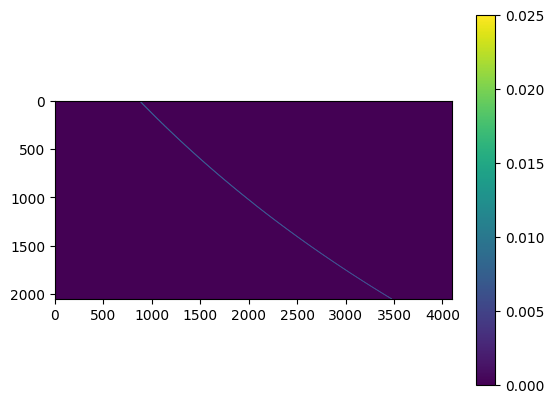

In [26]:
plt.imshow(data1)
plt.colorbar()

[800.0, 0.05, 0.000284634625279619, 0.0, 2.0, 0.0]

(1900.0, 2100.0)

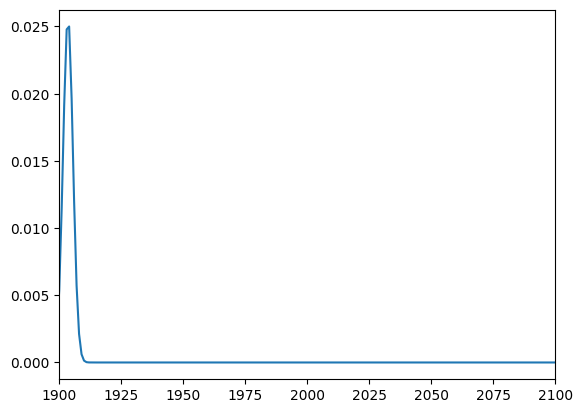

In [16]:
plt.plot(data1[1000])
plt.xlim(1900,2100)

In [17]:
Noise_mean = 0.01236756
Noise_std = 0.03109983
SN_per = data1 / Noise_std
SN_tot = np.sqrt(np.sum(SN_per**2))
print(SN_tot)

65.69595306639235


In [27]:
### save to a .dat file
# save to a float 32 binary .dat file
with open('test_injpulse6.dat', 'wb') as f:
    f.write(data1.tobytes())

65.69595306639235


100.18277433721092

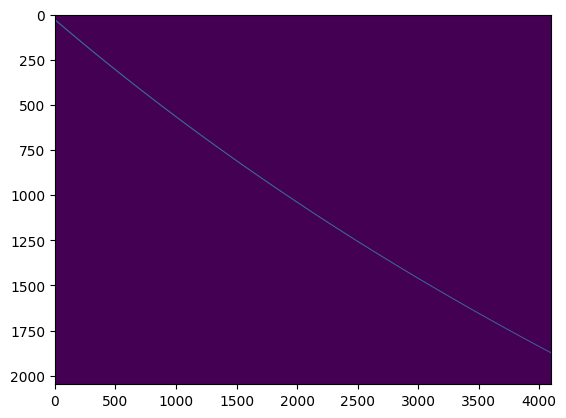

In [20]:
### read a .dat file 
myarray = np.memmap('test_injpulse5.dat', dtype=float)
test = np.reshape(myarray, newshape=(2048,4096))
plt.imshow(test, aspect='auto')
#plt.xlim(1785,2366)
SN_tot = np.sqrt(np.sum((test/Noise_std)**2))
print(SN_tot)
(2366-1785)*dt * 1e3 / 4.149 / (1/1.28**2-1/1.53**2)

# check the injection (cadence=10s)

In [4]:
#fnfil = '/hdd/data/filterbanks/grex-20240227T055600.fil' # 02/27 DM100, fluence = 0.05
#fnfil = '/hdd/data/filterbanks/grex-20240228T195520.fil' # bad RFI
#fnfil = '/hdd/data/filterbanks/grex-20240229T052755.fil' # 02/28 DM 150, fluence = 0.5
#fnfil = '/hdd/data/filterbanks/grex-20240229T194237.fil' # 02/29 DM 50, fluence = 0.02
#fnfil = '/hdd/data/filterbanks/grex-20240304T185801.fil' # test 03/04
fnfil = '/hdd/data/filterbanks/grex-20240305T004243.fil' # DM 800
# fnfil = '/home/jupyter-user/test.fil'
data, freq, dtime, header = at.read_fil_data_grex(fnfil, start=0, stop=167846)
dtime

0.000131072

In [5]:
freq

array([1529.93896484, 1529.8168349 , 1529.69470495, ..., 1280.18322474,
       1280.06109479, 1279.93896484])

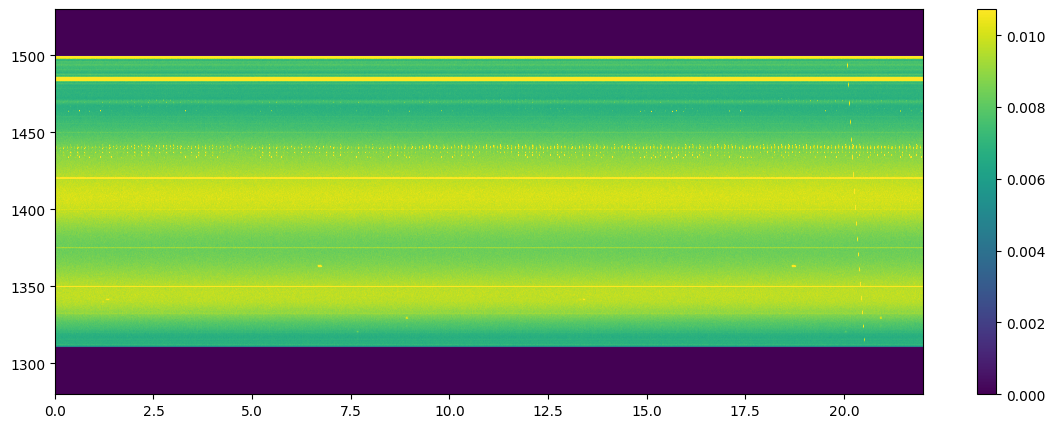

In [57]:
plt.figure(figsize=(14,5))
vmax = np.mean(data) + 1 * np.std(data)
plt.imshow(data, aspect='auto', vmax=vmax, extent=(0, dtime*data.shape[1], freq.min(), freq.max()))
plt.colorbar()

In [69]:
#t_delay = (10.33 - 10.217) * 1e3 # ms # DM = 150
#t_delay = (10.29 - 10.251) * 1e3 # ms # DM=50 
t_delay = (20.51 - 20.055) * 1e3 # DM=800
dm = t_delay/ 4.149 / (1/1.31**2-1/1.5**2)
print(dm)

793.1094971354356


(1310.0, 1500.0)

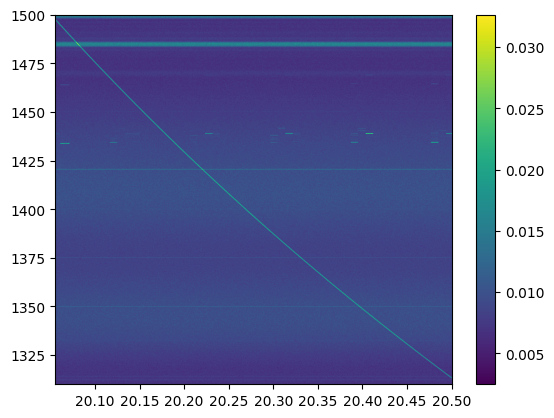

In [6]:
### 1380 MHz RFI...
vmax = np.mean(data) + 1 * np.std(data)
plt.imshow(data[:,int(20.055/21.999910912*167846): int(20.5/21.999910912*167846)], aspect='auto', vmax=vmax, extent=(20.055, 20.5, freq.min(), freq.max()))
plt.colorbar()
plt.ylim(1310,1500)

In [44]:
#zap 1370 - 1390 MHz
df = 250/2048
(freq.max()-1370)/df

1310.22

In [ ]:
### remove bad channels
# 1146-1310 channels  

# Check .cand files 

(cadence=60s)

In [34]:
test = np.loadtxt('/hdd/data/candidates/hd_cand/giants.cand', unpack=True)

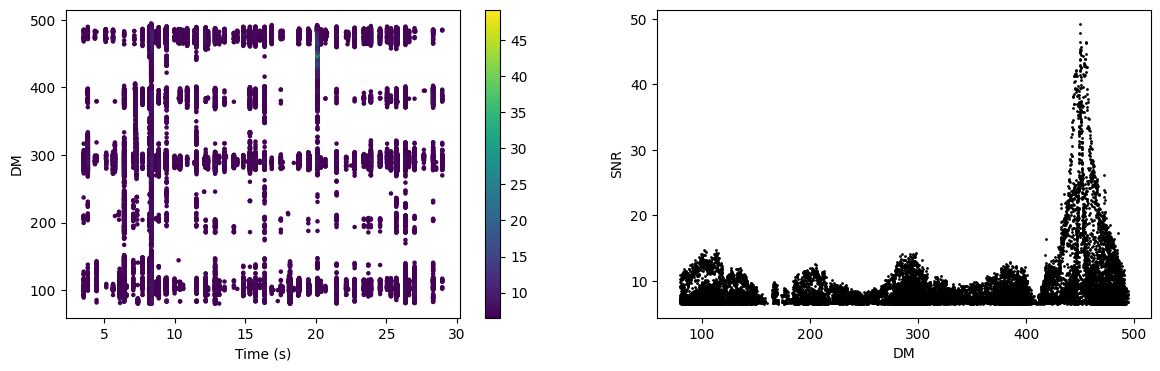

In [35]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.scatter(test[3], test[6], c=test[0],s=5)
#print(cand[3].min(), cand[3].max())
#plt.xlim(20.2,20.275)
plt.xlabel('Time (s)')
plt.ylabel('DM')
plt.subplot(1,2,2)
plt.plot(test[6], test[0], 'o', ms=1, color='black', alpha=1)
plt.xlabel('DM')
plt.ylabel('SNR')
plt.colorbar()


In [10]:
# cand = np.loadtxt('/hdd/data/candidates/T2/cluster_output1709185147.cand', unpack=True)
# snr0, if1, specnum2, mjds3, ibox4, idm5, dm6, ibeam7, cl8, cntc9, cntb10, trigger11
fn = np.loadtxt('./filename7.txt', dtype=str)


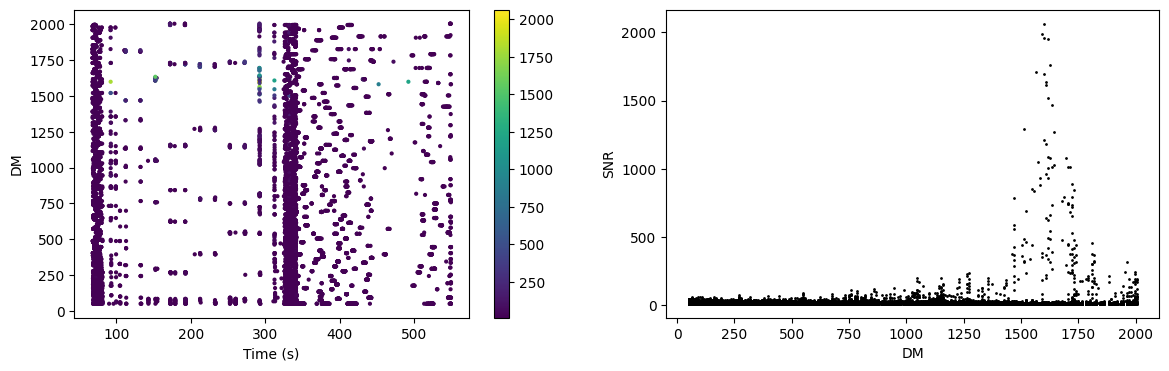

In [11]:
plt.figure(figsize=(14,4))

for i in range(len(fn)):
    #cand = np.loadtxt('/hdd/data/candidates/T2/{}'.format(fn[i]), unpack=True)
    cand = np.loadtxt(fn[i], unpack=True)
    plt.subplot(1,2,1)
    plt.scatter(cand[3], cand[6], c=cand[0],s=4)
    #print(cand[3].min(), cand[3].max())
    plt.xlabel('Time (s)')
    plt.ylabel('DM')
    plt.subplot(1,2,2)
    plt.plot(cand[6], cand[0], 'o', ms=1, color='black', alpha=1)
    plt.xlabel('DM')
    plt.ylabel('SNR')
    #print(cand[0].max())
#plt.xlim(1000,3000)
plt.colorbar()
# plt.axvline(55)
# plt.axvline(83)
# plt.axvline(28)

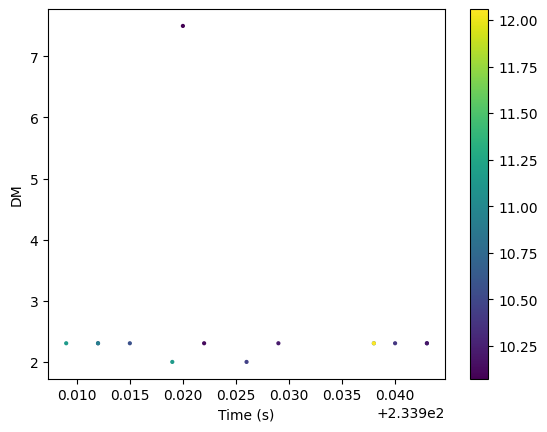

In [37]:
cand = np.loadtxt('/hdd/data/candidates/T2/{}'.format(fn[0]), unpack=True)
plt.scatter((cand[3]), cand[6], c=cand[0],s=4)
plt.xlabel('Time (s)')
plt.ylabel('DM')
plt.colorbar()

In [9]:
ls /hdd/data/candidates/T2/ | find /hdd/data/candidates/T2/ -type f -newermt '3/05/2024 12:10:00' | grep cluster_output17 > filename7.txt

ls: write error: Broken pipe


In [4]:
### 02/27-28 DM=100, fluence = 0.05 (S/N~70)
# ls /hdd/data/candidates/T2/ | grep 17091 > filename.txt 

### 02/28 DM=150, fluence = 0.5 (S/N~50)
# ls /hdd/data/candidates/T2/ | grep 170918 > filename1.txt 

### 02/28 DM=50, fluence = 0.02 (S/N~20)
# ls /hdd/data/candidates/T2/ | grep 17092 > filename2.txt

### ls *.cand | find . -type f -newermt '2/29/2024 14:00:00' | grep .cand  # redo the first case 

### 02/29 DM=100, fluence=0.1  (S/N~140)
#ls /hdd/data/candidates/T2/ | find /hdd/data/candidates/T2/ -type f -newermt '2/29/2024 20:20:00' | grep cluster_output17 > Injection/filename3.txt

### 02/29 DM=150, fluence=0.05, (S/N~70)
#ls /hdd/data/candidates/T2/ | find /hdd/data/candidates/T2/ -type f -newermt '2/29/2024 20:50:00' | grep cluster_output17 > Injection/filename4.txt